# 0.import modules and load csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tslearn.clustering import TimeSeriesKMeans
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import warnings 
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

warnings.filterwarnings('ignore')

C:\Users\Oran Nahum\AppData\Local\Temp\ipykernel_22184\885585466.py:15: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
original_df = pd.read_csv('sales_per_store_per_sku_ord_2.csv')
original_df

,store,sku,date,sales
0,1186,601516,2016-02-04,20.0
1,1186,601516,2016-02-05,11.0
2,1186,601516,2016-02-06,10.0
3,1186,601516,2016-02-08,10.0
4,1186,601516,2016-02-09,10.0
...,...,...,...,...
161524,194,100085056000002,2021-05-27,1.0
161525,194,100085056000002,2021-05-30,3.0
161526,194,100085056000002,2021-05-31,1.0
161527,194,100085056000002,2021-06-12,2.0


In [3]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161529 entries, 0 to 161528
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   store   161529 non-null  int64  
 1   sku     161529 non-null  int64  
 2   date    161529 non-null  object 
 3   sales   161529 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.9+ MB


# 1.Processing the data to create suitable dataframes

#### In the problem of product sales forecasting one of the most important features is the product <u>price</u>. Here this feature is not found in the data

In [4]:
original_df['date'] = pd.to_datetime(original_df['date'])

In [5]:
delta = original_df['date'].max() - original_df['date'].min()

In [6]:
delta

Timedelta('3601 days 00:00:00')

#### add count of day, month and year column

In [7]:
original_df['day_count'] = (original_df['date'] - original_df['date'].min()).dt.days
original_df['month_count'] = (original_df['date'].dt.year - original_df['date'].min().year) * 12 + original_df['date'].dt.month - original_df['date'].min().month
original_df['year_count'] = original_df['date'].dt.year - original_df['date'].min().year
original_df['day_of_week'] = original_df['date'].dt.dayofweek
original_df['day_of_month'] = original_df['date'].dt.day
original_df['day_of_week_name'] = original_df['date'].dt.day_name()
original_df['month_of_year'] = original_df['date'].dt.month
original_df['year'] = original_df['date'].dt.year

#### We can see that the store column has more then 1 column so we need pivot the dataframe with index by "day" columns by ['store','sku'] and values will be 'sales'. after that every nan fill with 0 = no sale

In [8]:
pivot_store_sku_original_df = original_df.pivot_table(values='sales', index='day_count', columns=['store','sku'])
pivot_store_sku_original_df = pivot_store_sku_original_df.fillna(0)
pivot_store_sku_original_df = pivot_store_sku_original_df.reindex(list(range(pivot_store_sku_original_df.index.min(),pivot_store_sku_original_df.index.max()+1)),fill_value=0)
pivot_store_sku_original_df

store                2               3               5                     \
sku       601105          601516          601900          601950            
day_count                                                                   
0                     0.0             0.0             0.0             0.0   
1                     1.0             0.0             0.0             0.0   
2                     0.0             0.0             0.0             0.0   
3                     1.0             0.0             0.0             0.0   
4                     2.0             0.0             0.0             0.0   
...                   ...             ...             ...             ...   
3597                  0.0             0.0             1.0             1.0   
3598                  0.0             0.0             4.0             0.0   
3599                  0.0             0.0             2.0             2.0   
3600                  0.0             0.0             0.0             0.0   
3601                  0.0             0.0             0.0             0.0   

store                                6               7                     \
sku       703007          601105          601515          601900            
day_count                                                                   
0                     0.0             0.0             0.0             0.0   
1                     0.0            20.0             0.0             0.0   
2                     0.0             0.0             0.0             0.0   
3                     0.0             0.0             0.0             0.0   
4                     0.0             1.0             0.0             0.0   
...                   ...             ...             ...             ...   
3597                  2.0             0.0             0.0             0.0   
3598                  0.0             0.0             0.0             2.0   
3599                  1.0             0.0             0.0             2.0   
3600                  0.0             0.0             0.0             0.0   
3601                  0.0             0.0             0.0             0.0   

store                8                     ...            2672  \
sku       601105          601900           ... 901000194         
day_count                                  ...                   
0                     2.0             0.0  ...             0.0   
1                     6.0             0.0  ...             0.0   
2                     0.0             0.0  ...             0.0   
3                     2.0             0.0  ...             0.0   
4                     4.0             0.0  ...             0.0   
...                   ...             ...  ...             ...   
3597                  0.0             2.0  ...             0.0   
3598                  0.0             6.0  ...             0.0   
3599                  0.0             2.0  ...             5.0   
3600                  0.0             0.0  ...             0.0   
3601                  0.0             0.0  ...             0.0   

store                2690                            2940            2970  \
sku       601105          601516          601516          601105            
day_count                                                                   
0                     1.0             0.0             0.0             0.0   
1                    21.0             0.0             0.0             0.0   
2                     0.0             0.0             0.0             0.0   
3                     0.0             0.0             0.0             0.0   
4                     0.0             0.0             0.0             2.0   
...                   ...             ...             ...             ...   
3597                  0.0             0.0             0.0             0.0   
3598                  0.0             0.0             0.0             0.0   
3599                  0.0             0.0             0.0             

In [9]:
pivot_store_sku_original_df.columns

MultiIndex([(   2,          601105),
            (   3,          601516),
            (   5,          601900),
            (   5,          601950),
            (   5,          703007),
            (   6,          601105),
            (   7,          601515),
            (   7,          601900),
            (   8,          601105),
            (   8,          601900),
            ...
            (2672,       901000194),
            (2690,          601105),
            (2690,          601516),
            (2940,          601516),
            (2970,          601105),
            (2970,          601920),
            (3335,       901000199),
            (4123,          601500),
            (5008,       901000198),
            (6301, 100028355000034)],
           names=['store', 'sku'], length=582)

#### plot example

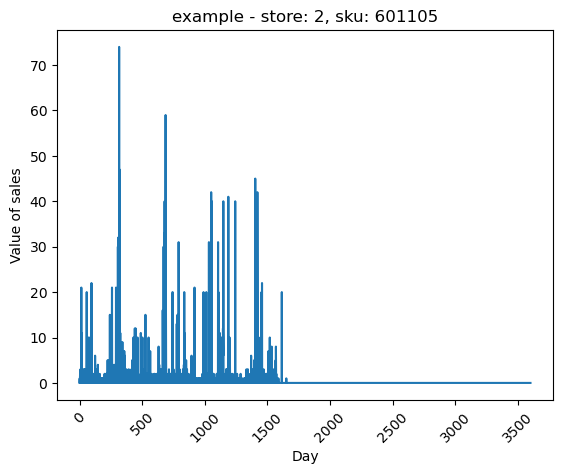

In [10]:
plt.plot(pivot_store_sku_original_df[(   2,          601105)])
plt.title('example - store: 2, sku: 601105')
plt.ylabel('Value of sales')
plt.xlabel("Day")
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45)
plt.show()

#### We see that there are probably areas with zeros (both in products and in stores). Because we want to predict the sale of products/stores in the recent period or in the future, we would like to have as few zero values as possible from 2017. Therefore we will create a new data frame like this and call it <u>df</u>. At the moment we will only work with him until further notice

In [11]:
original_df.pivot_table(index='day_count', columns='store', values='sales', fill_value=0, aggfunc=np.mean)

store,2,3,5,6,7,8,10,11,15,18,...,2610,2671,2672,2690,2940,2970,3335,4123,5008,6301
day_count,,,,,,,,,,,,,,,,,,,,,
0,0,0,0.000000,0,0,2.0,0,0.000000,30,0.0,...,0.0,1.0,0.0,1.0,0,0,0,0,0,0
1,1,0,0.000000,20,0,6.0,0,0.000000,12,0.0,...,0.0,0.0,0.0,21.0,0,0,0,0,0,0
2,0,0,0.000000,0,0,0.0,0,0.000000,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
3,1,0,0.000000,0,0,2.0,0,0.000000,3,1.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
4,2,0,0.000000,1,0,4.0,0,0.000000,19,1.0,...,28.0,2.0,0.0,0.0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3597,0,0,1.333333,0,0,1.5,0,10.500000,0,0.0,...,0.0,0.0,0.0,0.0,0,10,0,0,0,0
3598,0,0,4.000000,0,2,4.0,0,1.333333,1,0.0,...,0.0,0.0,0.0,0.0,0,20,0,0,0,0
3599,0,0,1.666667,0,2,2.0,0,3.333333,0,0.0,...,0.0,0.0,5.0,0.0,0,10,0,0,0,0


In [12]:
begining_of_2017_day_count = original_df[original_df['date'] == '31-12-2016']['day_count'].iloc[0]

In [13]:
agg_day_item_original_df = original_df.pivot_table(index='day_count', columns='sku', values='sales', fill_value=0, aggfunc=np.mean)
agg_day_item_original_df = agg_day_item_original_df.reindex(list(range(agg_day_item_original_df.index.min(), agg_day_item_original_df.index.max()+1)),fill_value=0)
agg_day_store_original_df = original_df.pivot_table(index='day_count', columns='store', values='sales', fill_value=0, aggfunc=np.mean)
agg_day_store_original_df = agg_day_store_original_df.reindex(list(range(agg_day_store_original_df.index.min(), agg_day_store_original_df.index.max()+1)),fill_value=0)

In [14]:
agg_day_store_original_df

store,2,3,5,6,7,8,10,11,15,18,...,2610,2671,2672,2690,2940,2970,3335,4123,5008,6301
day_count,,,,,,,,,,,,,,,,,,,,,
0,0,0,0.000000,0,0,2.0,0,0.000000,30,0.0,...,0.0,1.0,0.0,1.0,0,0,0,0,0,0
1,1,0,0.000000,20,0,6.0,0,0.000000,12,0.0,...,0.0,0.0,0.0,21.0,0,0,0,0,0,0
2,0,0,0.000000,0,0,0.0,0,0.000000,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
3,1,0,0.000000,0,0,2.0,0,0.000000,3,1.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
4,2,0,0.000000,1,0,4.0,0,0.000000,19,1.0,...,28.0,2.0,0.0,0.0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3597,0,0,1.333333,0,0,1.5,0,10.500000,0,0.0,...,0.0,0.0,0.0,0.0,0,10,0,0,0,0
3598,0,0,4.000000,0,2,4.0,0,1.333333,1,0.0,...,0.0,0.0,0.0,0.0,0,20,0,0,0,0
3599,0,0,1.666667,0,2,2.0,0,3.333333,0,0.0,...,0.0,0.0,5.0,0.0,0,10,0,0,0,0


In [15]:
zeros_sales_sku_2017 = []
for sku in agg_day_item_original_df[begining_of_2017_day_count:]:
    value = agg_day_item_original_df[begining_of_2017_day_count:][sku].value_counts()[0] / len(agg_day_item_original_df[begining_of_2017_day_count:])
    zeros_sales_sku_2017.append(value)
zeros_sales_sku_2017_original_df = pd.Series(zeros_sales_sku_2017, index=agg_day_item_original_df.columns)    

zeros_sales_store_2017 = []
for sku in agg_day_store_original_df[begining_of_2017_day_count:]:
    value = agg_day_store_original_df[begining_of_2017_day_count:][sku].value_counts()[0] / len(agg_day_store_original_df[begining_of_2017_day_count:])
    zeros_sales_store_2017.append(value)
zeros_sales_store_2017_original_df = pd.Series(zeros_sales_store_2017, index=agg_day_store_original_df.columns)  

#### take skus and stores with zeros precentege below 40% from 2017

<AxesSubplot: xlabel='day_count'>

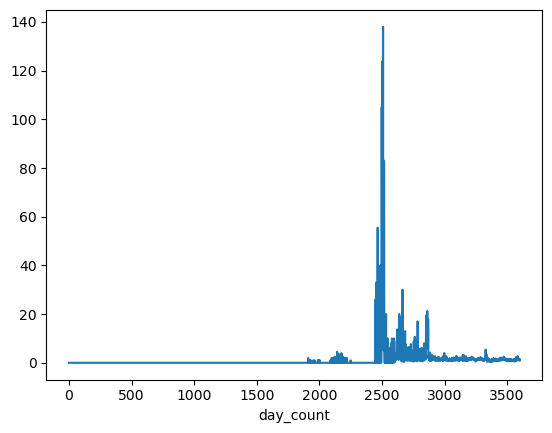

In [16]:
agg_day_store_original_df[194].plot()

In [17]:
zeros_ratio = 0.4
top_skus = zeros_sales_sku_2017_original_df[zeros_sales_sku_2017_original_df.sort_values() < zeros_ratio].index
top_stores = zeros_sales_store_2017_original_df[zeros_sales_store_2017_original_df.sort_values() < zeros_ratio].index

In [18]:
top_skus, top_stores

(Int64Index([601900, 601950, 703007, 901000205], dtype='int64', name='sku'),
 Int64Index([5, 8, 11, 42, 67, 82, 96, 109, 181, 317, 1070, 2310], dtype='int64', name='store'))

#### lets plot top 3 (sku & store) without zeros from 2017

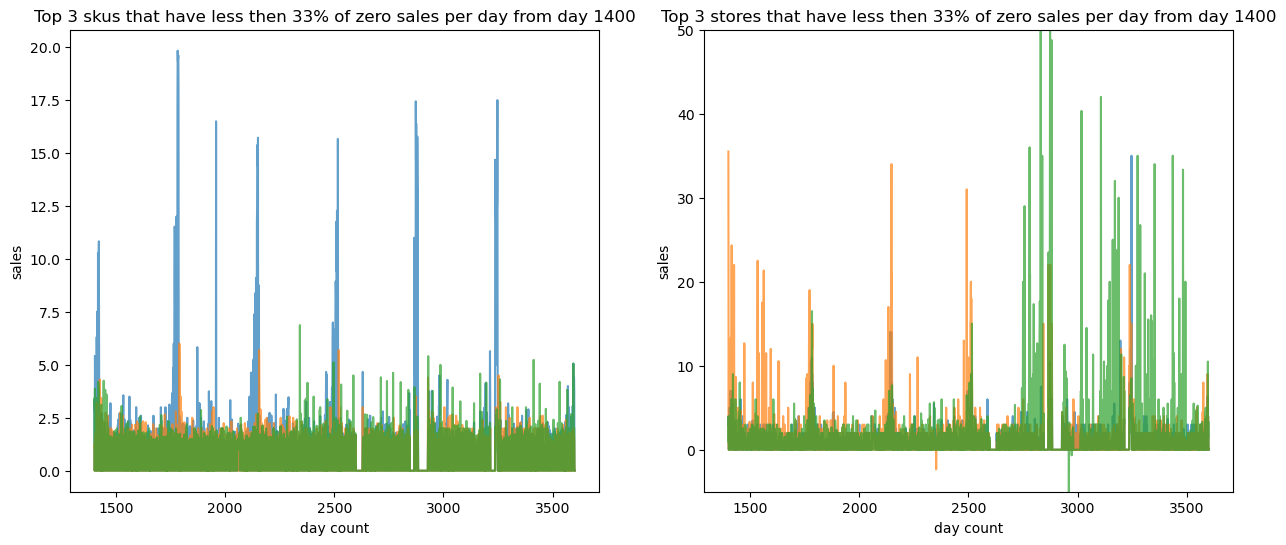

In [19]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(agg_day_item_original_df[top_skus[:3]][1400:], alpha = 0.7)
plt.xlabel("day count")
plt.title("Top 3 skus that have less then 33% of zero sales per day from day 1400")
plt.ylabel("sales")
plt.subplot(122)
plt.plot(agg_day_store_original_df[top_stores[:3]][1400:], alpha = 0.7)
plt.ylim((-5,50))
plt.xlabel("day count")
plt.title("Top 3 stores that have less then 33% of zero sales per day from day 1400")
plt.ylabel("sales")
plt.show()

In [20]:
top_stores

Int64Index([5, 8, 11, 42, 67, 82, 96, 109, 181, 317, 1070, 2310], dtype='int64', name='store')

#### We see behavior almost without zero regions.

In [21]:
original_df[(np.isin(original_df["sku"], top_skus))][original_df[(np.isin(original_df["sku"], top_skus))]["store"] == 190]

,store,sku,date,sales,day_count,month_count,year_count,day_of_week,day_of_month,day_of_week_name,month_of_year,year
50080,190,703007,2017-01-09,0.0,1438,47,4,0,9,Monday,1,2017
50081,190,703007,2017-01-11,0.0,1440,47,4,2,11,Wednesday,1,2017
50082,190,703007,2017-01-12,0.0,1441,47,4,3,12,Thursday,1,2017
50083,190,703007,2017-01-13,0.0,1442,47,4,4,13,Friday,1,2017
50084,190,703007,2017-01-16,0.0,1445,47,4,0,16,Monday,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
50157,190,703007,2017-06-13,0.0,1593,52,4,1,13,Tuesday,6,2017
50158,190,703007,2017-06-16,0.0,1596,52,4,4,16,Friday,6,2017
50159,190,703007,2017-06-19,0.0,1599,52,4,0,19,Monday,6,2017
50160,190,703007,2017-06-20,0.0,1600,52,4,1,20,Tuesday,6,2017


In [22]:
df_store = original_df[np.isin(original_df["store"], top_stores)]
df_sku = original_df[(np.isin(original_df["sku"], top_skus))]
df = pd.merge(df_store, df_sku, how="outer")
df = df[df["day_count"] > begining_of_2017_day_count]
df['date_str'] = str(df['date'])
part_of_week = []
for index in df.index:
    if (df.loc[index]['day_of_week'] > 5)  or (df.loc[index]['day_of_week'] == 1):
        part_of_week.append('Weekend')
    else: 
        part_of_week.append("Middle_of_the_week")
df['part_of_week'] = part_of_week

#### from now Only uses with <u>df</u> unless otherwise noted

#### Now we will make a new pivot dfs with mean aggregation for each store. We will see sales of all products in a particular store. We will fill the missing indices of days and fill the values with zeros

In [23]:
agg_day_item_df = df.pivot_table(index='day_count', columns='sku', values='sales', fill_value=0, aggfunc=np.mean)
agg_day_item_df = agg_day_item_df.reindex(list(range(agg_day_item_df.index.min(), agg_day_item_df.index.max()+1)),fill_value=0)
agg_day_store_df = df.pivot_table(index='day_count', columns='store', values='sales', fill_value=0, aggfunc=np.mean)
agg_day_store_df = agg_day_store_df.reindex(list(range(agg_day_store_df.index.min(), agg_day_store_df.index.max()+1)),fill_value=0)

agg_month_item_df = df.pivot_table(index='month_count', columns='sku', values='sales', fill_value=0, aggfunc=np.mean)
agg_month_item_df = agg_month_item_df.reindex(list(range(agg_month_item_df.index.min(), agg_month_item_df.index.max()+1)),fill_value=0)
agg_month_store_df = df.pivot_table(index='month_count', columns='store', values='sales', fill_value=0, aggfunc=np.mean)
agg_month_store_df = agg_month_store_df.reindex(list(range(agg_month_store_df.index.min(), agg_month_store_df.index.max()+1)),fill_value=0)

agg_year_item_df = df.pivot_table(index='year_count', columns='sku', values='sales', fill_value=0, aggfunc=np.mean)
agg_year_item_df = agg_year_item_df.reindex(list(range(agg_year_item_df.index.min(), agg_year_item_df.index.max()+1)),fill_value=0)
agg_year_store_df = df.pivot_table(index='year_count', columns='store', values='sales', fill_value=0, aggfunc=np.mean)
agg_year_store_df = agg_year_store_df.reindex(list(range(agg_year_store_df.index.min(), agg_year_store_df.index.max()+1)),fill_value=0)

In [24]:
agg_day_store_df

store,5,7,8,11,21,22,34,42,51,63,...,160,164,181,183,190,225,317,1070,2210,2310
day_count,,,,,,,,,,,,,,,,,,,,,
1431,1.000000,3,3.500000,1.500000,0,0,0,6.500000,0,1.0,...,1.5,0,1.500000,2,0,0,79.000000,2.333333,0,1.0
1432,2.000000,0,2.500000,6.000000,0,2,0,1.666667,0,4.0,...,4.0,0,2.500000,1,0,0,11.666667,4.333333,0,0.0
1433,3.500000,0,4.500000,4.000000,0,2,2,1.666667,0,4.0,...,0.0,2,1.000000,0,0,0,14.000000,2.333333,0,0.0
1434,3.000000,0,8.666667,2.000000,4,2,0,3.000000,2,0.0,...,4.0,0,2.000000,3,0,0,9.000000,2.000000,0,1.0
1435,0.000000,0,0.000000,0.000000,0,0,0,0.000000,0,0.0,...,0.0,0,0.000000,0,0,0,0.000000,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,6.333333,2,9.000000,4.250000,3,6,0,3.333333,5,4.5,...,3.0,5,5.333333,6,0,1,0.000000,2.750000,0,1.0
3596,2.333333,4,3.000000,3.500000,10,0,0,3.000000,2,3.5,...,3.5,2,3.666667,0,0,1,0.000000,3.800000,0,1.0
3597,1.333333,0,1.500000,10.500000,0,2,0,1.000000,1,0.0,...,2.0,1,3.000000,0,0,0,1.000000,0.000000,0,0.0


In [25]:
agg_month_store_df

store,5,7,8,11,21,22,34,42,51,63,...,160,164,181,183,190,225,317,1070,2210,2310
month_count,,,,,,,,,,,,,,,,,,,,,
47,2.032258,1.500000,2.969697,2.319149,1.461538,2.625000,3.000000,3.656716,2.909091,1.826087,...,2.230769,2.400000,2.370370,1.384615,0,0.000000,14.387097,1.939024,0.000000,1.470588
48,1.441176,2.000000,2.295775,1.666667,2.000000,1.461538,1.285714,2.622642,1.416667,1.571429,...,1.470588,1.142857,8.446809,2.066667,0,0.000000,7.880000,2.479452,0.000000,1.615385
49,1.486486,1.444444,1.944444,1.456522,2.000000,1.250000,1.100000,2.318182,1.812500,1.300000,...,1.454545,1.200000,2.785714,2.142857,0,0.000000,8.681818,2.107143,0.000000,1.964286
50,1.906977,3.500000,3.557377,1.960784,1.941176,1.384615,1.200000,4.017544,1.550000,1.607143,...,1.656250,1.500000,4.907407,3.153846,0,0.000000,3.311111,1.929577,1.933333,1.916667
51,1.692308,1.923077,4.650000,1.681818,1.928571,1.272727,1.200000,2.859155,2.000000,1.500000,...,1.266667,1.705882,2.245614,2.090909,0,0.000000,2.217391,1.797101,2.181818,3.052632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1.282051,1.750000,1.433333,5.604651,1.142857,1.363636,0.000000,1.891304,1.636364,1.400000,...,1.500000,1.500000,1.375000,1.500000,0,1.500000,3.229167,2.068966,0.000000,2.675676
115,1.393939,1.000000,1.111111,1.644444,1.363636,1.307692,0.000000,1.956522,1.666667,1.363636,...,1.304348,1.846154,1.700000,1.363636,0,1.333333,3.478261,1.890411,0.000000,2.242424
116,1.368421,1.500000,1.880000,2.320000,1.444444,2.076923,0.000000,1.977273,1.400000,1.538462,...,1.684211,1.416667,1.531250,1.500000,0,1.400000,2.500000,2.291139,0.000000,1.600000


In [26]:
agg_day_item_arr = agg_day_item_df.values
agg_day_store_arr = agg_day_store_df.values

Text(0, 0.5, 'Relative Sales')

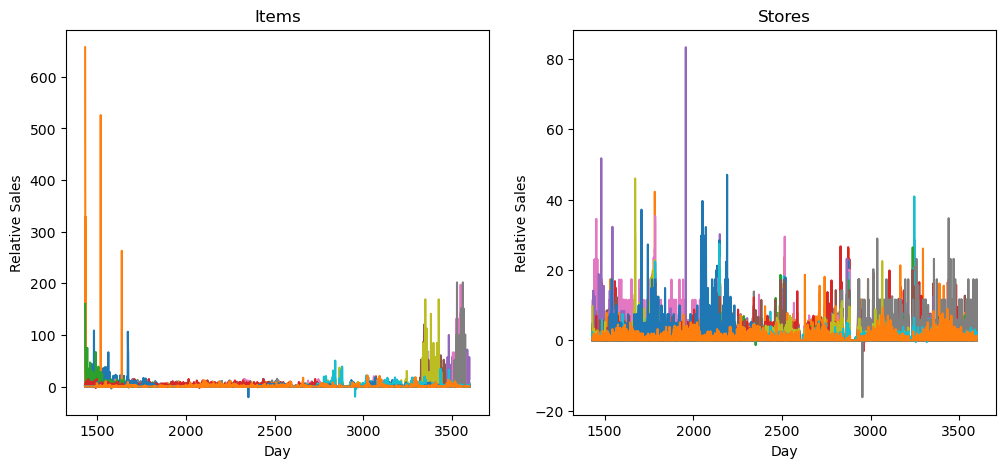

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_day_item_df.index, agg_day_item_arr / agg_day_item_arr.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Day")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_day_store_df.index, agg_day_store_arr / agg_day_store_arr.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Day")
plt.ylabel("Relative Sales")

#### We will make some plots that will help us conclude which day of the week has more or less sales and which month has more or less sales.

In [28]:
agg_dow_month_df = df.pivot_table(index='day_of_week', columns='month_of_year', values='sales', aggfunc=np.mean).fillna(0)
agg_dom_year_df = df.pivot_table(index='day_of_month', columns='month_of_year', values='sales', aggfunc=np.mean).fillna(0)
agg_moy_year_df = df.pivot_table(index='month_of_year', columns='year', values='sales', aggfunc=np.mean).fillna(0)
agg_dow_year_df = df.pivot_table(index='day_of_week', columns='year', values='sales', aggfunc=np.mean).fillna(0)


In [29]:
day_of_week_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

Text(0, 0.5, 'Relative Sales')

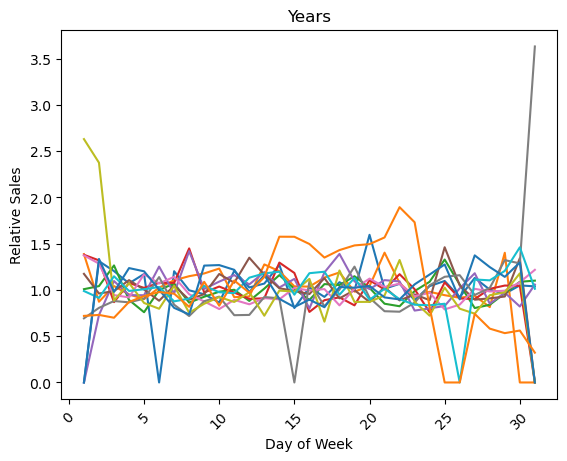

In [30]:
plt.plot(agg_dom_year_df / agg_dom_year_df.values.mean(0)[np.newaxis])
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45)
plt.title("Years")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")

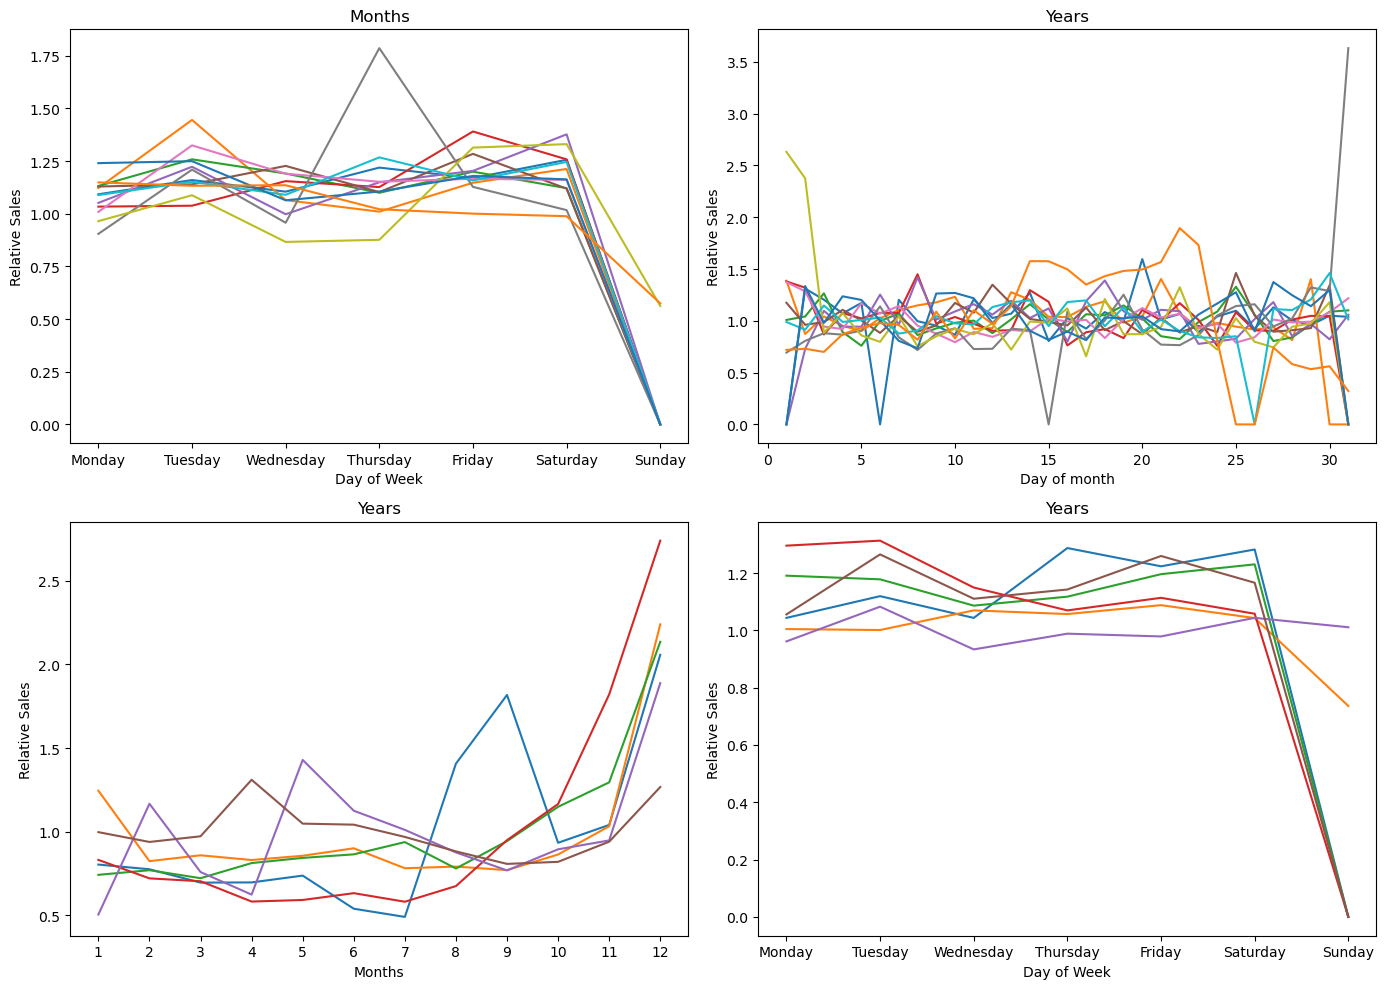

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs[0, 0].plot(day_of_week_list, agg_dow_month_df / agg_dow_month_df.values.mean(0)[np.newaxis])
axs[0, 0].set_title("Months")
axs[0, 0].set_xlabel("Day of Week")
axs[0, 0].set_ylabel("Relative Sales")
axs[0, 1].plot(agg_dom_year_df / agg_dom_year_df.values.mean(0)[np.newaxis])
axs[0, 1].set_title("Years")
axs[0, 1].set_xlabel("Day of month")
axs[0, 1].set_ylabel("Relative Sales")
axs[1, 0].plot(agg_moy_year_df / agg_moy_year_df.values.mean(0)[np.newaxis])
axs[1, 0].set_xticks(np.arange(1,13))
axs[1, 0].set_title("Years")
axs[1, 0].set_xlabel("Months")
axs[1, 0].set_ylabel("Relative Sales")
axs[1, 1].plot(day_of_week_list, agg_dow_year_df / agg_dow_year_df.values.mean(0)[np.newaxis])
axs[1, 1].set_title("Years")
axs[1, 1].set_xlabel("Day of Week")
axs[1, 1].set_ylabel("Relative Sales")
fig.tight_layout()
plt.show()

#### It can be seen that there is a decrease in sales on the weekend (Saturday and Sunday). And it can be seen that there is an increase in sales towards the end of the year (November and December). There is no trend in the day of the month.

#### What about the item-store relationship?


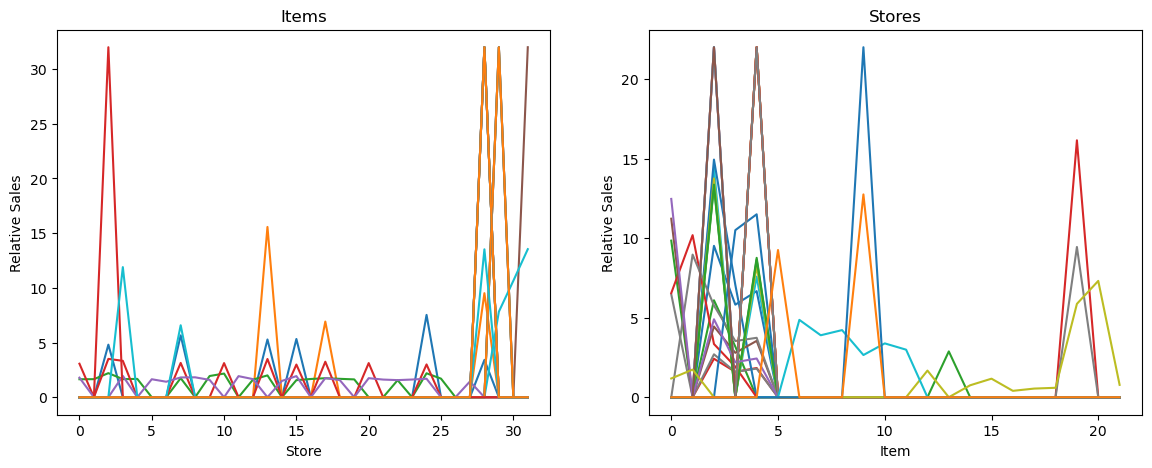

In [32]:
agg_store_item = df.pivot_table(index='store', columns='sku', values='sales', aggfunc=np.mean)
agg_store_item = agg_store_item.fillna(0)

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_store_item.values / agg_store_item.values.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Store")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_store_item.T.values / agg_store_item.values.T.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Item")
plt.ylabel("Relative Sales")
plt.show()

#### we can see different segments. There are products that are sold in many stores and there are products that are sold in a few stores. There are stores that sell more products and there are stores that sell less products. It can be seen that the quantities vary between sales of certain stores and the quantities vary in the sales of specific products.

# 2.Statistical review

#### We will find the most appropriate time rolling after using correlation with a different rolling with mean aggregation. We will look for where there are peaks.

In [33]:
def roll_forward(series, steps):
    return pd.Series(np.roll(series.values, steps), index = series.index)

In [34]:
def find_correllation_from_different_rolling(agg_df, min_roll, max_roll):
    max_roll = len(agg_df)
    rolling_corr_sum = [0] * len(range(min_roll, max_roll))
    for number in agg_day_store_df:
      #  print(number)
        for roll_size in range(min_roll, max_roll):
           # print(roll_size)
            rolled_forward_series = roll_forward(agg_day_store_df[number], roll_size)
            corr_value = np.corrcoef(rolled_forward_series, agg_day_store_df[number])[0][1]
            if corr_value != corr_value: 
                rolling_corr_sum[roll_size-min_roll] += 0 
            else:  
            #    print("11111")
                rolling_corr_sum[roll_size-min_roll] += corr_value 
            #print(rolling_corr_sum)
    rolling_corr_avg = np.array(rolling_corr_sum) / len(agg_day_store_df.columns)
    return np.nan_to_num(rolling_corr_avg)

#### Because this calculation takes some time. And we want to calculate it on both agg_day_store_df and agg_day_item_df. 

In [35]:
agg_day_item_df

sku,601105,601516,601900,601950,703007,901000193,901000198,901000201,901000202,901000205,...,251000000001,100009399000001,100060062000001,100065553000001,100080119000002,100080129000001,100630157000002,201888014000001,201999999990002,201999999990007
day_count,,,,,,,,,,,,,,,,,,,,,
1431,7.00,10,1.454545,2.666667,2.250000,1,0,4,0,0.0,...,79,0,0,0,0,0,0,0.0,0,0
1432,3.20,6,1.666667,3.428571,3.111111,0,0,7,0,0.0,...,28,0,0,0,0,0,0,0.0,0,0
1433,6.00,0,1.166667,2.400000,3.000000,0,0,2,0,1.0,...,14,2,0,0,0,0,0,0.0,0,0
1434,12.25,5,2.714286,1.666667,2.600000,0,0,1,1,1.0,...,13,0,0,0,0,0,0,0.0,0,0
1435,0.00,0,0.000000,0.000000,0.000000,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,0.00,0,5.058824,1.750000,5.055556,0,0,1,5,1.0,...,0,0,0,0,0,0,0,10.0,0,0
3596,0.00,0,4.500000,1.571429,1.642857,1,0,3,8,4.0,...,0,0,0,0,0,0,0,0.0,0,0
3597,0.00,0,1.625000,1.750000,1.600000,0,0,0,0,0.0,...,0,0,1,0,0,0,0,10.5,0,0


In [36]:
agg_day_store_df

store,5,7,8,11,21,22,34,42,51,63,...,160,164,181,183,190,225,317,1070,2210,2310
day_count,,,,,,,,,,,,,,,,,,,,,
1431,1.000000,3,3.500000,1.500000,0,0,0,6.500000,0,1.0,...,1.5,0,1.500000,2,0,0,79.000000,2.333333,0,1.0
1432,2.000000,0,2.500000,6.000000,0,2,0,1.666667,0,4.0,...,4.0,0,2.500000,1,0,0,11.666667,4.333333,0,0.0
1433,3.500000,0,4.500000,4.000000,0,2,2,1.666667,0,4.0,...,0.0,2,1.000000,0,0,0,14.000000,2.333333,0,0.0
1434,3.000000,0,8.666667,2.000000,4,2,0,3.000000,2,0.0,...,4.0,0,2.000000,3,0,0,9.000000,2.000000,0,1.0
1435,0.000000,0,0.000000,0.000000,0,0,0,0.000000,0,0.0,...,0.0,0,0.000000,0,0,0,0.000000,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,6.333333,2,9.000000,4.250000,3,6,0,3.333333,5,4.5,...,3.0,5,5.333333,6,0,1,0.000000,2.750000,0,1.0
3596,2.333333,4,3.000000,3.500000,10,0,0,3.000000,2,3.5,...,3.5,2,3.666667,0,0,1,0.000000,3.800000,0,1.0
3597,1.333333,0,1.500000,10.500000,0,2,0,1.000000,1,0.0,...,2.0,1,3.000000,0,0,0,1.000000,0.000000,0,0.0


In [37]:
min_roll = 1
max_roll = len(agg_day_store_df) 

In [38]:
rolling_corr_store_avg = find_correllation_from_different_rolling(agg_day_store_df, min_roll, max_roll)

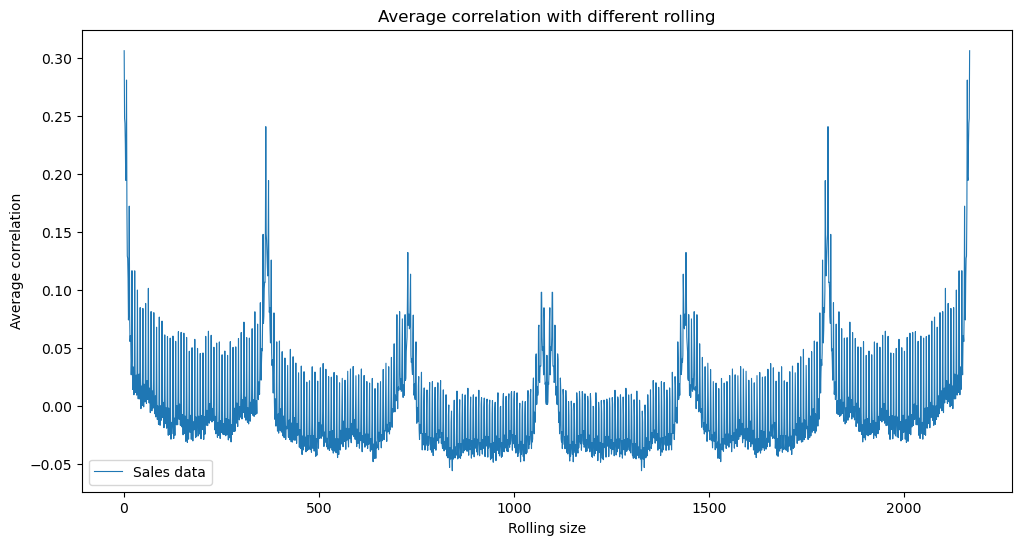

In [39]:
plt.figure(figsize=(12,6))
plt.plot(range(min_roll, max_roll), rolling_corr_store_avg, label='Sales data', linewidth=0.8)

plt.title("Average correlation with different rolling")
plt.xlabel("Rolling size")
plt.ylabel("Average correlation")
plt.legend()

plt.show()

#### The resulting function is an even function, so we will look for the peaks only in the left half of the graph. In itam data there are no peaks and there are no cycles in the correlation. On the other hand, store data has peaks. lets find the first pick

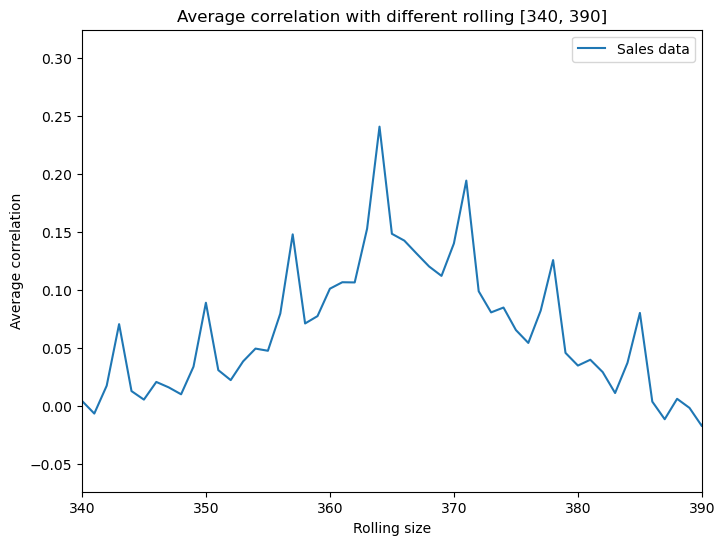

In [40]:
plt.figure(figsize=(8,6))
plt.plot(range(min_roll, max_roll), rolling_corr_store_avg, label='Sales data')
plt.title("Average correlation with different rolling [340, 390]")
plt.xlabel("Rolling size")
plt.ylabel("Average correlation")
plt.legend()
plt.xlim([340, 390])
plt.show()

#### its look like the first pick in store data is Rolling size = 365 (full year). It can be concluded that there is a certain correlation between the behavior of sales in a certain store on a certain date and the behavior of sales in the same store one year (exactly) forward or backward

#### lets find the best correlation between stores with rolling : 365 days

In [41]:
def find_correllation_from_different_stores(agg_df, roll_size=365):
    rolling_stores_corr = []
    for store in agg_df:
        rolled_forward_series = roll_forward(agg_df[store], roll_size)
        corr_value = np.corrcoef(rolled_forward_series, agg_df[store])[0][1]
        rolling_stores_corr.append(corr_value)
    return pd.DataFrame(rolling_stores_corr, index=agg_day_store_df.columns, columns=['365 period rolling correlation value'])

In [42]:
df_best_stores_corr_365 = find_correllation_from_different_stores(agg_day_store_df)
df_best_stores_corr_365 = df_best_stores_corr_365.fillna(0)
df_best_stores_corr_365 = df_best_stores_corr_365.sort_values('365 period rolling correlation value')

#### lets plot the best store with original sales and 365 days rolling

In [43]:
df_best_stores_corr_365

,365 period rolling correlation value
store,
317,-0.073951
143,-0.026885
88,-0.004184
190,0.000000
181,0.013997
51,0.015004
141,0.016146
164,0.020308
1070,0.023647


In [44]:
df_best_stores_corr_365['365 period rolling correlation value'].sort_values().index[-1]

136

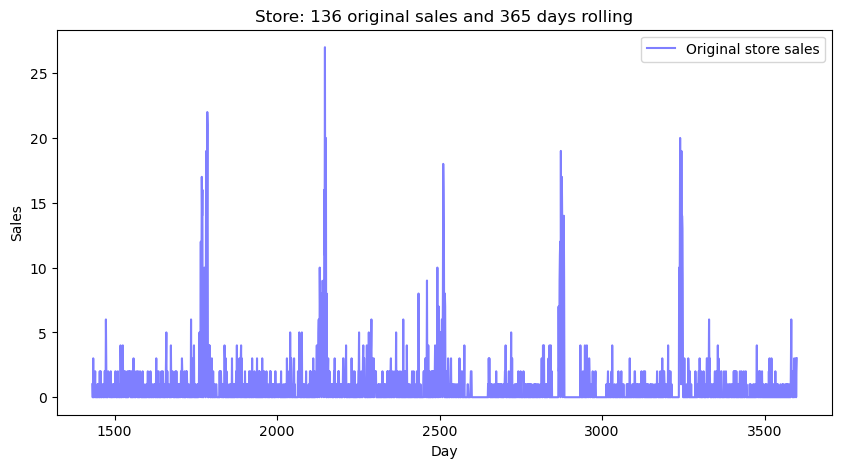

In [45]:
best_corr_store = df_best_stores_corr_365['365 period rolling correlation value'].sort_values().index[-1]
plt.figure(figsize=(10,5))
#plt.plot(roll_forward(agg_day_store_df[best_corr_store], 365), alpha=0.5, c='r', label='365 days rolling')
plt.plot(agg_day_store_df[best_corr_store], alpha=0.5, c='b', label='Original store sales')
plt.ylabel("Sales")
plt.xlabel("Day")
plt.legend()
plt.title("Store: " + str(best_corr_store) + " original sales and 365 days rolling")
plt.show()

#### zoom in

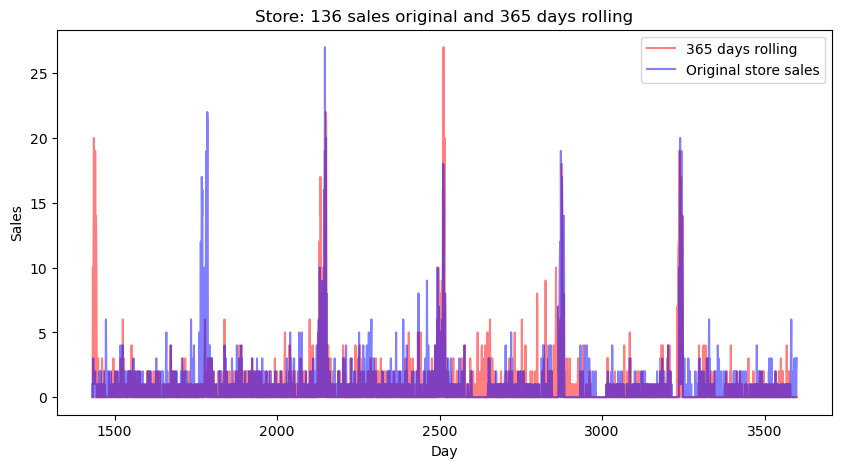

In [46]:
plt.figure(figsize=(10,5))
plt.plot(roll_forward(agg_day_store_df[best_corr_store], 365), alpha=0.5, c='r', label='365 days rolling')
plt.plot(agg_day_store_df[best_corr_store], alpha=0.5, c='b', label='Original store sales')
plt.ylabel("Sales")
plt.xlabel("Day")
plt.legend()
plt.title("Store: " + str(best_corr_store) + " sales original and 365 days rolling")
plt.show()

Text(0, 0.5, 'sales')

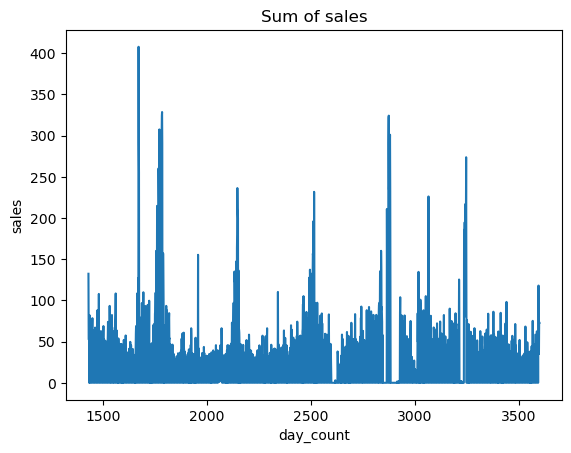

In [47]:
sum_df = agg_day_store_df[agg_day_store_df.columns].sum(axis=1)
sum_df.plot()
plt.title("Sum of sales")
plt.ylabel("sales")

#### we can see the correlation. lets plot ACF & PACF

In [48]:
sum_df

day_count
1431    132.333333
1432     67.166667
1433     52.250000
1434     69.166667
1435      0.000000
           ...    
3595    118.000000
3596     67.466667
3597     34.833333
3598     73.833333
3599     72.666667
Length: 2169, dtype: float64

In [49]:
agg_day_store_df[agg_day_store_df.columns[:10]]

store,5,7,8,11,21,22,34,42,51,63
day_count,,,,,,,,,,
1431,1.000000,3,3.500000,1.500000,0,0,0,6.500000,0,1.0
1432,2.000000,0,2.500000,6.000000,0,2,0,1.666667,0,4.0
1433,3.500000,0,4.500000,4.000000,0,2,2,1.666667,0,4.0
1434,3.000000,0,8.666667,2.000000,4,2,0,3.000000,2,0.0
1435,0.000000,0,0.000000,0.000000,0,0,0,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...
3595,6.333333,2,9.000000,4.250000,3,6,0,3.333333,5,4.5
3596,2.333333,4,3.000000,3.500000,10,0,0,3.000000,2,3.5
3597,1.333333,0,1.500000,10.500000,0,2,0,1.000000,1,0.0


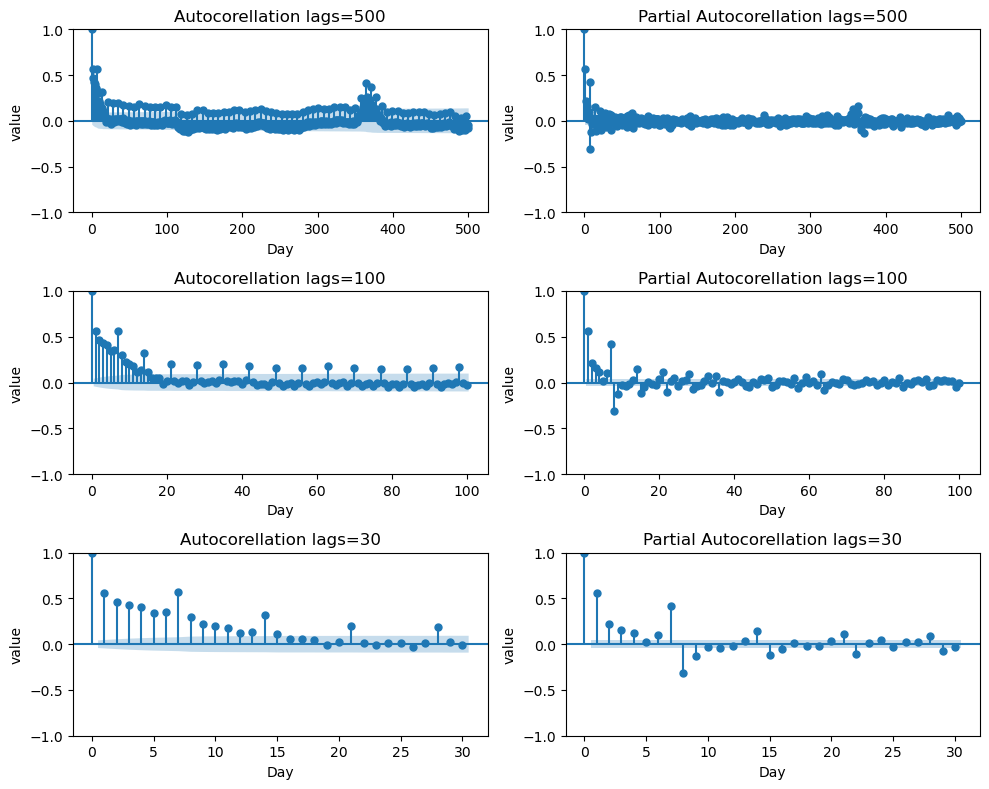

In [50]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8))

plot_acf(sum_df, lags=500, ax=ax[0][0])
plot_pacf(sum_df, lags=500, ax=ax[0][1])
plot_acf(sum_df, lags=100, ax=ax[1][0])
plot_pacf(sum_df, lags=100, ax=ax[1][1])
plot_acf(sum_df, lags=30, ax=ax[2][0])
plot_pacf(sum_df, lags=30, ax=ax[2][1])

ax[0][0].set_xlabel("Day")
ax[0][1].set_xlabel("Day")
ax[1][0].set_xlabel("Day")
ax[1][1].set_xlabel("Day")
ax[2][0].set_xlabel("Day")
ax[2][1].set_xlabel("Day")
ax[0][0].set_ylabel("value")
ax[0][1].set_ylabel("value")
ax[1][0].set_ylabel("value")
ax[1][1].set_ylabel("value")
ax[2][0].set_ylabel("value")
ax[2][1].set_ylabel("value")
ax[0][0].set_title("Autocorellation lags=500")
ax[0][1].set_title("Partial Autocorellation lags=500")
ax[1][0].set_title("Autocorellation lags=100")
ax[1][1].set_title("Partial Autocorellation lags=100")
ax[2][0].set_title("Autocorellation lags=30")
ax[2][1].set_title("Partial Autocorellation lags=30")

plt.tight_layout()

#### We can see a correlation in behavior every year (365 days) and every week (7 days)

#### Let's make a plot of the average sales per year, month on every year, and day of every week

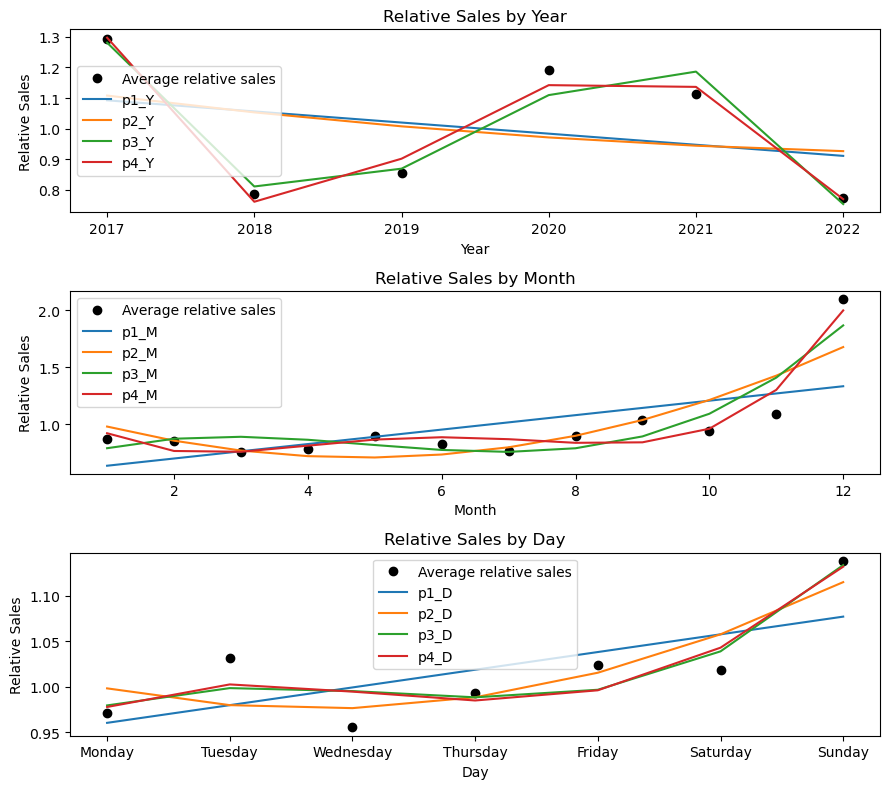

In [51]:
df = df[(np.isin(df["store"], top_stores)) | (np.isin(df["sku"], top_skus))][begining_of_2017_day_count:]

grand_avg = df.sales.mean()

year_table = df.pivot_table(index='year', values='sales', aggfunc=np.mean)
year_table /= grand_avg
years = np.arange(df['date'].min().year, df['date'].max().year+1)
annual_sales_avg = year_table.values.squeeze()

fig, axes = plt.subplots(3, 1, figsize=(9, 8))
p1_y = np.poly1d(np.polyfit(years, annual_sales_avg, 1))
p2_y = np.poly1d(np.polyfit(years, annual_sales_avg, 2))
p3_y = np.poly1d(np.polyfit(years, annual_sales_avg, 3))
p4_y = np.poly1d(np.polyfit(years, annual_sales_avg, 4))

axes[0].plot(years, annual_sales_avg, 'ko', label='Average relative sales')
axes[0].plot(years, p1_y(years), 'C0-', label='p1_Y')
axes[0].plot(years, p2_y(years), 'C1-', label='p2_Y')
axes[0].plot(years, p3_y(years), 'C2-', label='p3_Y')
axes[0].plot(years, p4_y(years), 'C3-', label='p4_Y')
axes[0].set_title("Relative Sales by Year")
axes[0].set_ylabel("Relative Sales")
axes[0].set_xlabel("Year")
axes[0].legend()

month_table = df.pivot_table(index='month_of_year', values='sales', aggfunc=np.mean)
month_table.sales /= grand_avg
month_list = np.arange(1,13)
month_sales_avg = month_table.values.squeeze()

p1_m = np.poly1d(np.polyfit(month_list, month_sales_avg, 1))
p2_m = np.poly1d(np.polyfit(month_list, month_sales_avg, 2))
p3_m = np.poly1d(np.polyfit(month_list, month_sales_avg, 3))
p4_m = np.poly1d(np.polyfit(month_list, month_sales_avg, 4))

axes[1].plot(month_list, month_sales_avg, 'ko', label='Average relative sales')
axes[1].plot(month_list, p1_m(month_list), 'C0-', label='p1_M')
axes[1].plot(month_list, p2_m(month_list), 'C1-', label='p2_M')
axes[1].plot(month_list, p3_m(month_list), 'C2-', label='p3_M')
axes[1].plot(month_list, p4_m(month_list), 'C3-', label='p4_M')

axes[1].set_title("Relative Sales by Month")
axes[1].set_ylabel("Relative Sales")
axes[1].set_xlabel("Month")
axes[1].legend()

dow_table = df.pivot_table(index='day_of_week', values='sales', aggfunc=np.mean)
dow_table.sales /= grand_avg
day_of_week_array = np.arange(0,7)
day_sales_avg = dow_table.values.squeeze()

p1_d = np.poly1d(np.polyfit(day_of_week_array, day_sales_avg, 1))
p2_d = np.poly1d(np.polyfit(day_of_week_array, day_sales_avg, 2))
p3_d = np.poly1d(np.polyfit(day_of_week_array, day_sales_avg, 3))
p4_d = np.poly1d(np.polyfit(day_of_week_array, day_sales_avg, 4))

axes[2].plot(day_of_week_list, day_sales_avg, 'ko', label='Average relative sales')
axes[2].plot(day_of_week_list, p1_d(day_of_week_array), 'C0-', label='p1_D')
axes[2].plot(day_of_week_list, p2_d(day_of_week_array), 'C1-', label='p2_D')
axes[2].plot(day_of_week_list, p3_d(day_of_week_array), 'C2-', label='p3_D')
axes[2].plot(day_of_week_list, p4_d(day_of_week_array), 'C3-', label='p4_D')

axes[2].set_title("Relative Sales by Day")
axes[2].set_ylabel("Relative Sales")
axes[2].set_xlabel("Day")
axes[2].legend()

plt.tight_layout()

In [52]:
trend_df = df.pivot_table(values=['month_of_year', 'year', 'day_of_week'], index='date')
trend_df.reindex(pd.date_range(start='2017-01-01', end='2022-12-10', freq='D'), fill_value=0)

,day_of_week,month_of_year,year
2017-01-01,0,0,0
2017-01-02,0,1,2017
2017-01-03,1,1,2017
2017-01-04,2,1,2017
2017-01-05,3,1,2017
...,...,...,...
2022-12-06,1,12,2022
2022-12-07,2,12,2022
2022-12-08,3,12,2022
2022-12-09,4,12,2022


In [53]:
trend_array = []
for index in trend_df.index:
    year_trend = p4_y(trend_df.loc[index]['year'])
    month_trend = p4_m(trend_df.loc[index]['month_of_year'])
    day_trend = p4_d(trend_df.loc[index]['day_of_week'])
    trend_array.append(year_trend * month_trend * day_trend)
trend_df["trend_Sales"] = trend_array    

In [54]:
future_date_df = pd.DataFrame(pd.date_range(start = '2022-12-10', periods=100, freq='D'), columns=['date'])
future_date_df['day_of_week'] = future_date_df['date'].dt.dayofweek
future_date_df['month_of_year'] = future_date_df['date'].dt.month
future_date_df['year'] = future_date_df['date'].dt.year
future_trend = []
for date in future_date_df["date"]:
    year_trend = p4_y(future_date_df[future_date_df["date"] == date]['year'])
    month_trend = p4_m(future_date_df[future_date_df["date"] == date]['month_of_year'])
    day_trend = p4_d(future_date_df[future_date_df["date"] == date]['day_of_week'])
    future_trend.append((year_trend * month_trend * day_trend)[0])
future_date_df["trend_Sales"] = future_trend

#### Let's smooth the values

In [55]:
ysmoothed_history = gaussian_filter1d(trend_df["trend_Sales"], sigma=3)
ysmoothed_future = gaussian_filter1d(future_date_df["trend_Sales"], sigma=3)

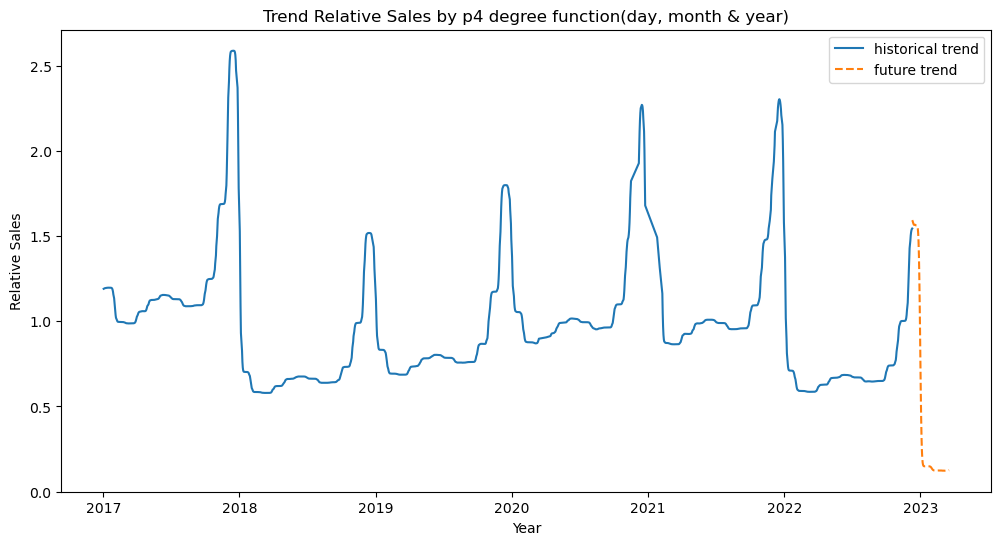

In [56]:
plt.figure(figsize=(12,6))
plt.plot(trend_df.index, ysmoothed_history, label='historical trend')
plt.plot(future_date_df['date'], ysmoothed_future,'--', label='future trend')
plt.title("Trend Relative Sales by p4 degree function(day, month & year)")
plt.ylabel("Relative Sales")
plt.xlabel("Year")
plt.legend()
plt.show()

#### We have 3 trends of which 2 are recurring trends the first is the trend of the total sale as a function of the day of the week and the second is the trend of the total sale as a function of the month of the year. This trend seems a bit illogical (relative sales drop close to 0).

#### First we want to perform clustering and this will be done when we take the points we found in the previous prints (2 trends). And an absolute difference will be made between these points and the points of the relative price of each of the stations/products#### First we want to perform clustering and this will be done when we take the points we found in the previous prints (2 trends). And an absolute difference will be made between these points and the points of the relative price of each of the stores/items

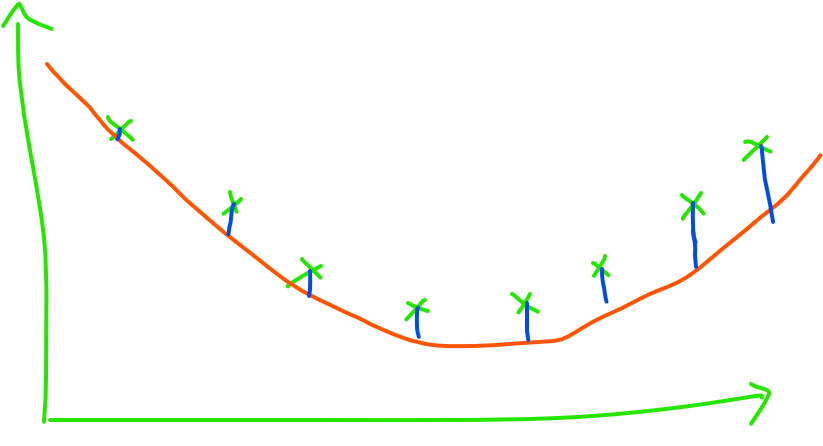

#### We will create 4 data frames:
#### 1 for different stores with weekday indexes
#### 1 for different stores with indexes of one month of the year
#### 1 for different sku with weekday indexes
#### 1 for different sku with indexes of one month of the year

In [57]:
stores_day_df = df.pivot_table(values='sales', index=['day_of_week'], columns='store', aggfunc=np.average).fillna(0)
stores_day_df /= stores_day_df.mean()
stores_month_df = df.pivot_table(values='sales', index=['month_of_year'], columns='store', aggfunc=np.average).fillna(0)
stores_month_df /= stores_month_df.mean()
sku_day_df = df.pivot_table(values='sales', index=['day_of_week'], columns='sku', aggfunc=np.average).fillna(0)
sku_day_df /= sku_day_df.mean()
sku_month_df = df.pivot_table(values='sales', index=['month_of_year'], columns='sku', aggfunc=np.average).fillna(0)
sku_month_df /= sku_month_df.mean()

In [58]:
store_dist_from_sales_avg_day = pd.Series([0] * len(stores_day_df.columns), index=stores_day_df.columns)
store_dist_from_sales_avg_month = pd.Series([0] * len(stores_day_df.columns), index=stores_day_df.columns)
sku_dist_from_sales_avg_day = pd.Series([0] * len(sku_day_df.columns), index=sku_day_df.columns)
sku_dist_from_sales_avg_month = pd.Series([0] * len(sku_day_df.columns), index=sku_day_df.columns)

for store in stores_day_df:
    MAE = sum(abs(stores_day_df[store] - day_sales_avg)) / 7
    store_dist_from_sales_avg_day.loc[store] = MAE
for store in stores_month_df:
    MAE = sum(abs(stores_month_df[store] - month_sales_avg)) / 12
    store_dist_from_sales_avg_month.loc[store] = MAE
for sku in sku_day_df:
    MAE = sum(abs(sku_day_df[sku] - day_sales_avg)) / 7
    sku_dist_from_sales_avg_day.loc[sku] = MAE
for sku in sku_month_df:
    MAE = sum(abs(sku_month_df[sku] - month_sales_avg)) / 12    
    sku_dist_from_sales_avg_month.loc[sku] = MAE

#### print best values:

In [59]:
print("Top 10 closest stores sales to total average in days on the week:")
print(store_dist_from_sales_avg_day.sort_values()[:10])
print("Top 10 closest stores sales to total average in month on the year:")
print(store_dist_from_sales_avg_month.sort_values()[:10])
print("Top 10 closest sku sales to total average in days on the week:")
print(sku_dist_from_sales_avg_day.sort_values()[:10])
print("Top 10 closest sku sales to total average in month on the year:")
print(sku_dist_from_sales_avg_month.sort_values()[:10])

Top 10 closest stores sales to total average in days on the week:
store
1070    0.041266
82      0.042686
109     0.057381
160     0.061100
96      0.067346
63      0.077915
42      0.079203
104     0.085399
117     0.099730
88      0.124160
dtype: float64
Top 10 closest stores sales to total average in month on the year:
store
11      0.090912
42      0.119349
109     0.126526
160     0.132573
117     0.145215
73      0.146346
96      0.148989
51      0.160640
1070    0.162745
5       0.189609
dtype: float64
Top 10 closest sku sales to total average in days on the week:
sku
703007             0.082420
601950             0.087215
901000201          0.115003
601900             0.169581
901000206          0.172242
901000202          0.220177
201888014000001    0.294384
201999999990002    0.302681
201999999990007    0.306387
901000217          0.306387
dtype: float64
Top 10 closest sku sales to total average in month on the year:
sku
901000202          0.120189
901000217          0.177435

#### We will print the 5 closest results in each category compared to the overall average.

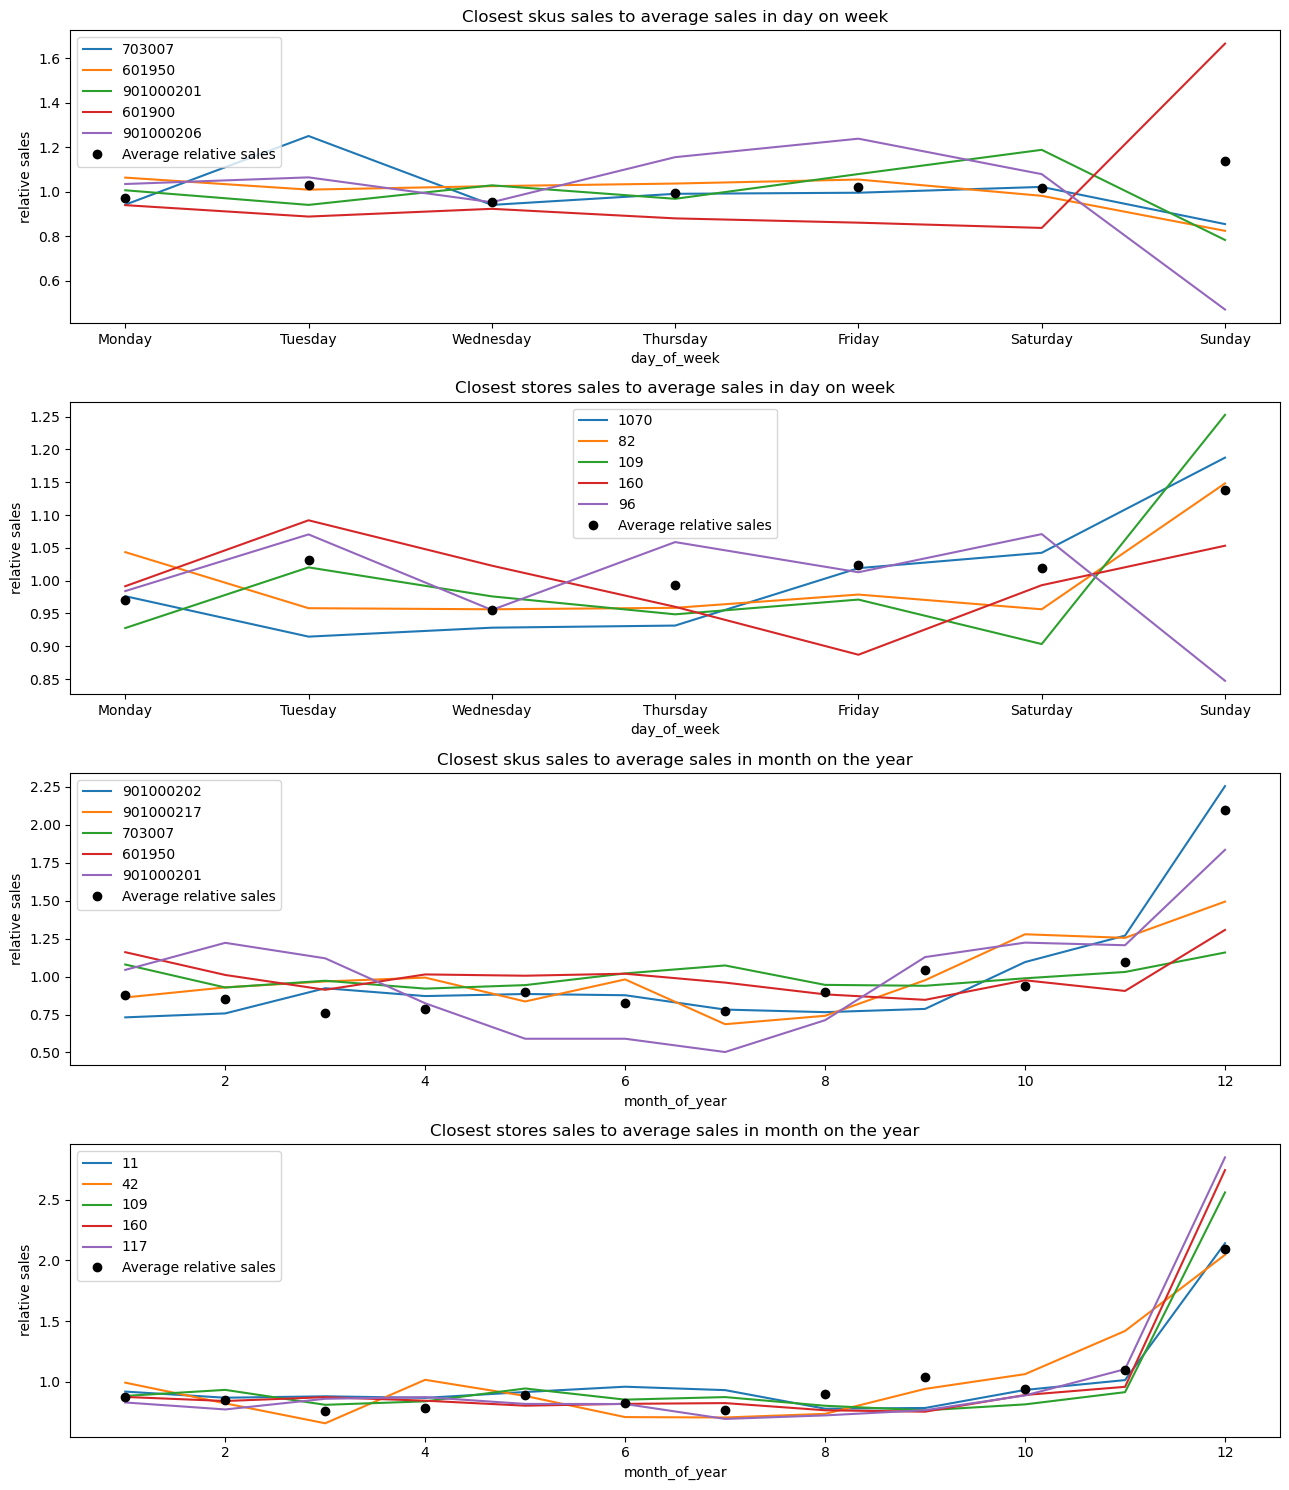

In [60]:
fig, axes = plt.subplots(4, 1, figsize=(13, 15))
sku_day_df[sku_dist_from_sales_avg_day.sort_values()[:5].index.values].plot(ax=axes[0])
stores_day_df[store_dist_from_sales_avg_day.sort_values()[:5].index.values].plot(ax=axes[1])
sku_month_df[sku_dist_from_sales_avg_month.sort_values()[:5].index.values].plot(ax=axes[2])
stores_month_df[store_dist_from_sales_avg_month.sort_values()[:5].index.values].plot(ax=axes[3])
for i in range(2):
    axes[i].plot(day_of_week_list, day_sales_avg, 'ko', label='Average relative sales')
    axes[i+2].plot(month_list, month_sales_avg, 'ko', label='Average relative sales')
    axes[i].legend()
    axes[i+2].legend()
    axes[i].set_ylabel("relative sales")
    axes[i+2].set_ylabel("relative sales")
axes[0].set_title("Closest skus sales to average sales in day on week")
axes[1].set_title("Closest stores sales to average sales in day on week")
axes[2].set_title("Closest skus sales to average sales in month on the year")
axes[3].set_title("Closest stores sales to average sales in month on the year")

plt.tight_layout()

In [61]:
agg_day_item_df_relative = agg_day_item_df.fillna(0) / agg_day_item_df.mean()
agg_day_store_df_relative = agg_day_store_df.fillna(0) / agg_day_store_df.mean()

#### we want cluster some stores with simillar behavior with Dynamic Time Warping

In [62]:
#x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
#y = np.array([[2,2], [3,3], [4,4]])#
#distance, path = fastdtw(x, y, dist=euclidean)
#print(distance)

In [63]:
#model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
#model.fit(agg_day_store_df[agg_month_store_df.columns[:10]].transpose())
#y=model.predict(agg_day_store_df[agg_month_store_df.columns[:10]].transpose())


In [64]:
best_sku_trend_per_day = sku_dist_from_sales_avg_day.sort_values().index[0]
best_store_trend_per_day = store_dist_from_sales_avg_day.sort_values().index[0]

#### We print the seasonal_decompose in sku and the store that are closest to the general trend at the weekly level.

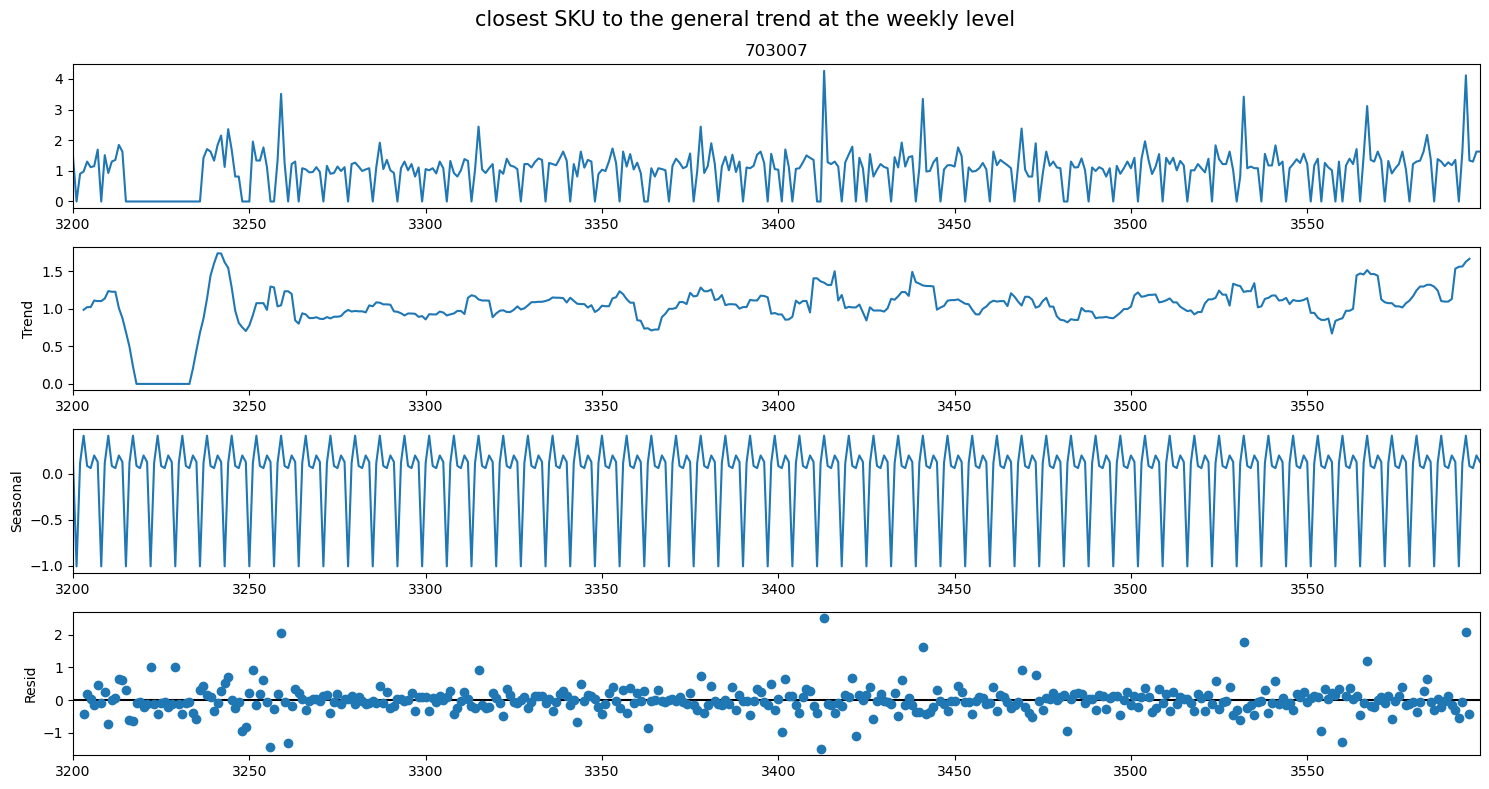

In [65]:
result = seasonal_decompose(agg_day_item_df_relative[best_sku_trend_per_day][-400:], model='additive', period=7)
fig = result.plot()  
fig.set_size_inches(15, 8)
fig.suptitle("closest SKU to the general trend at the weekly level", fontsize= 15)
fig.tight_layout()
fig.show()

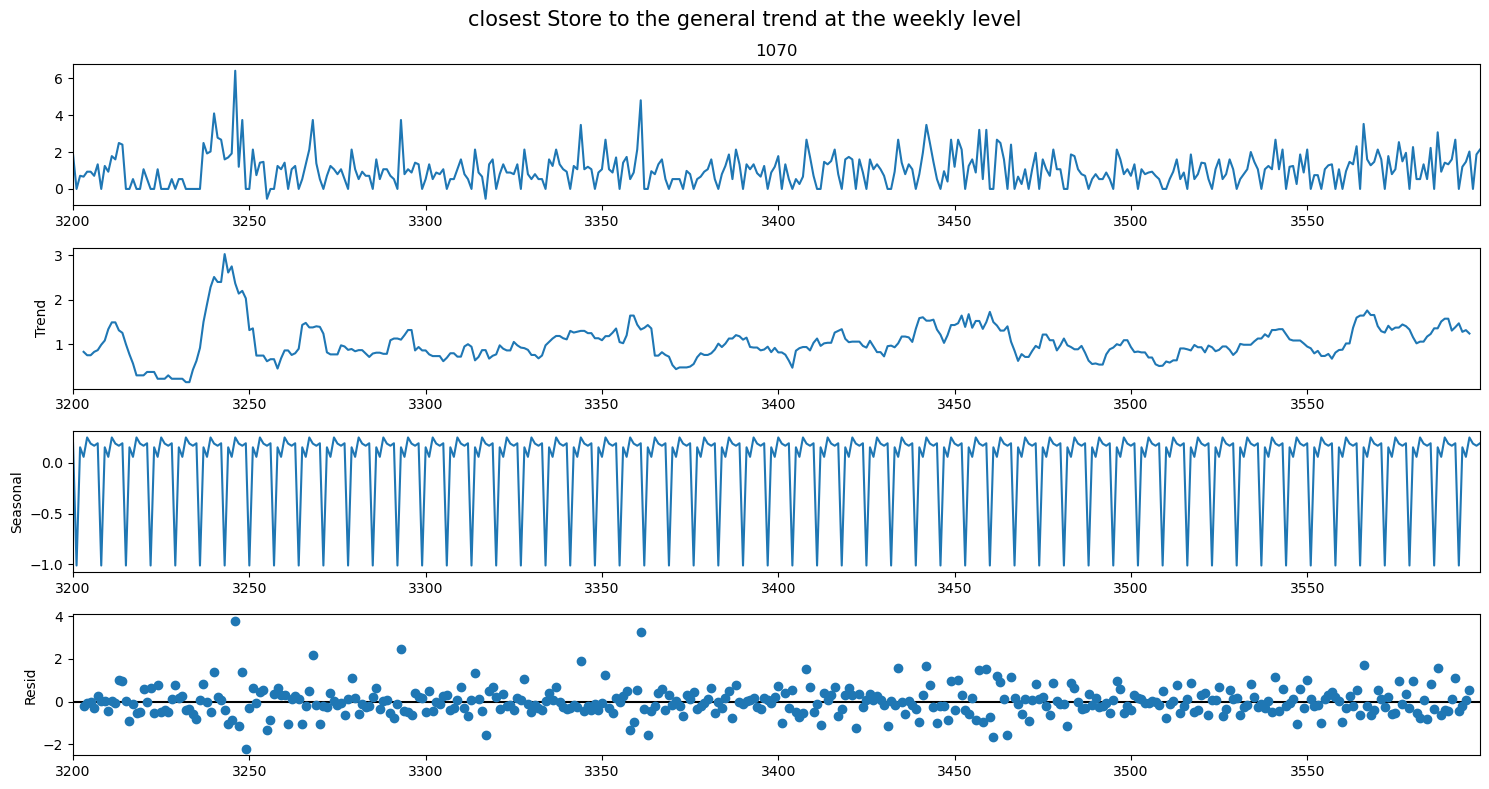

In [67]:
result = seasonal_decompose(agg_day_store_df_relative[best_store_trend_per_day][-400:], model='additive', period=7)
fig = result.plot()  
fig.set_size_inches(15, 8)
fig.suptitle("closest Store to the general trend at the weekly level", fontsize= 15)
fig.tight_layout()
fig.show()

#### You can see the annual trend (towards the end of the year there is an increase) and the weekly trend (weekend no sales). Sales are in a fairly stable range.

#### We want to turn the series at this time into a stationary series.

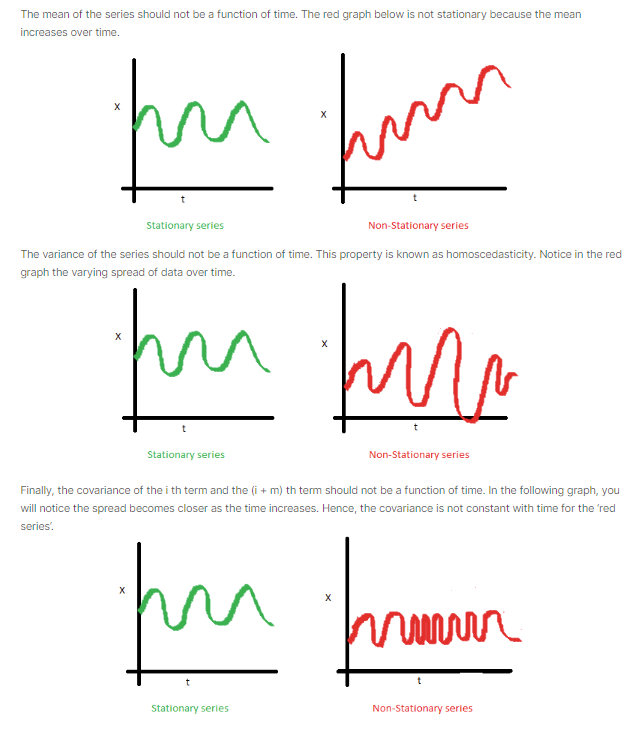
from : https://www.kaggle.com/code/sumi25/understand-arima-and-tune-p-d-q

#### Because the task is to predict the sales of the largest store, we will make a prediction for this store = 1070

In [68]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [69]:
best_store_sales_trend = agg_day_store_df_relative[best_store_trend_per_day]

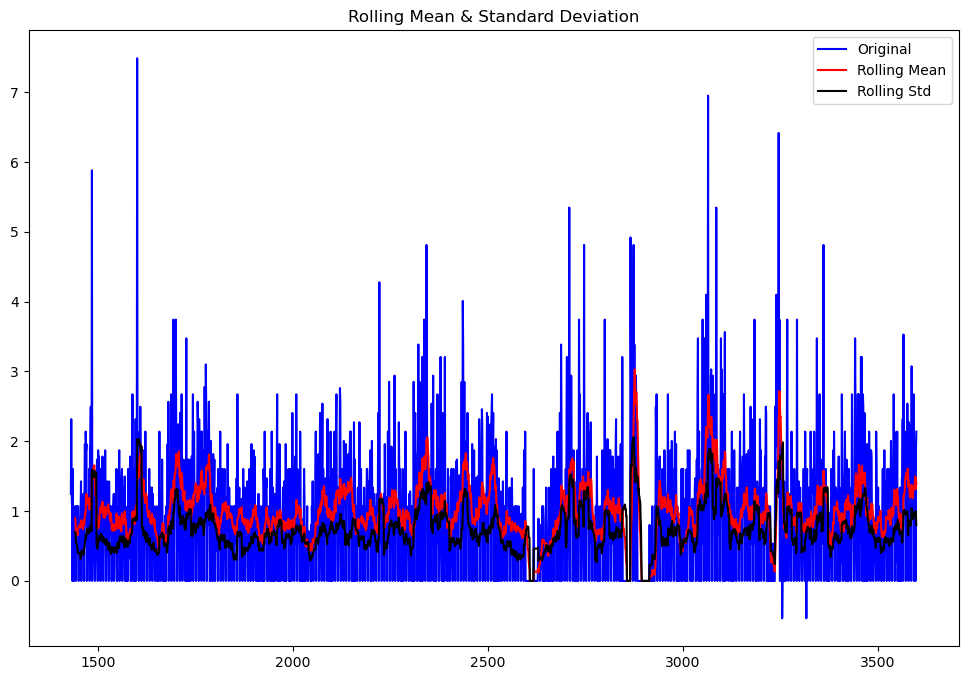

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.212733e+00
p-value                        2.213134e-10
#Lags Used                     2.000000e+01
Number of Observations Used    2.148000e+03
Critical Value (1%)           -3.433398e+00
Critical Value (5%)           -2.862886e+00
Critical Value (10%)          -2.567487e+00
dtype: float64


In [70]:
test_stationarity(best_store_sales_trend)

In [71]:
best_store_sales_trend.diff()

day_count
1431         NaN
1432    1.069263
1433   -1.069263
1434   -0.178211
1435   -1.069263
          ...   
3595    0.267316
3596    0.561363
3597   -2.031600
3598    1.871210
3599    0.267316
Name: 1070, Length: 2169, dtype: float64

#### lets do it more stationary

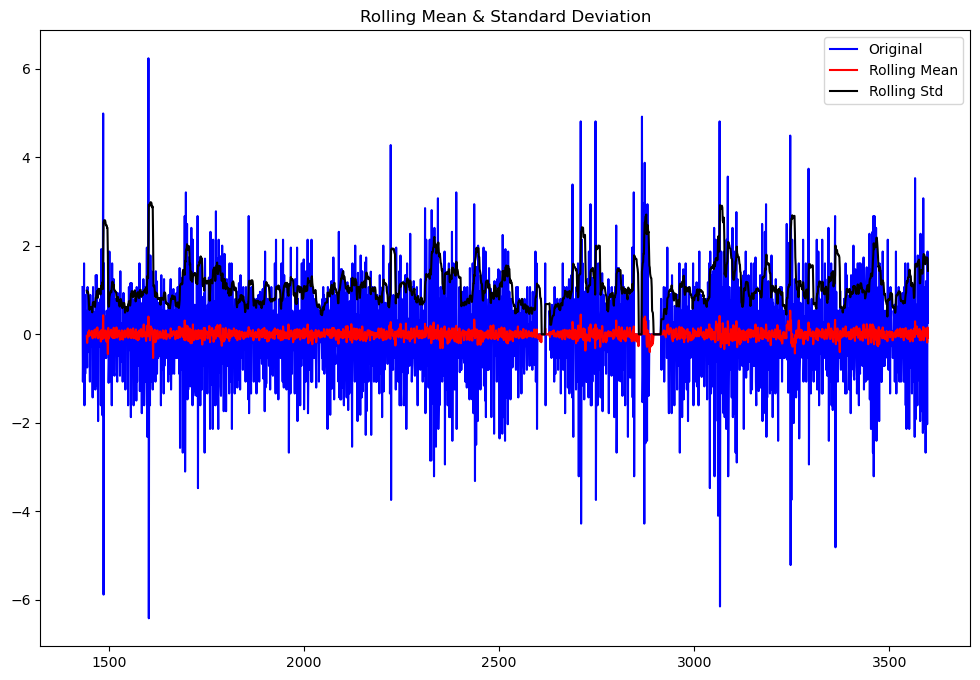

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.692831e+01
p-value                        9.820837e-30
#Lags Used                     1.900000e+01
Number of Observations Used    2.148000e+03
Critical Value (1%)           -3.433398e+00
Critical Value (5%)           -2.862886e+00
Critical Value (10%)          -2.567487e+00
dtype: float64


In [72]:
first_diff = best_store_sales_trend.diff().dropna(inplace = False)
test_stationarity(first_diff)

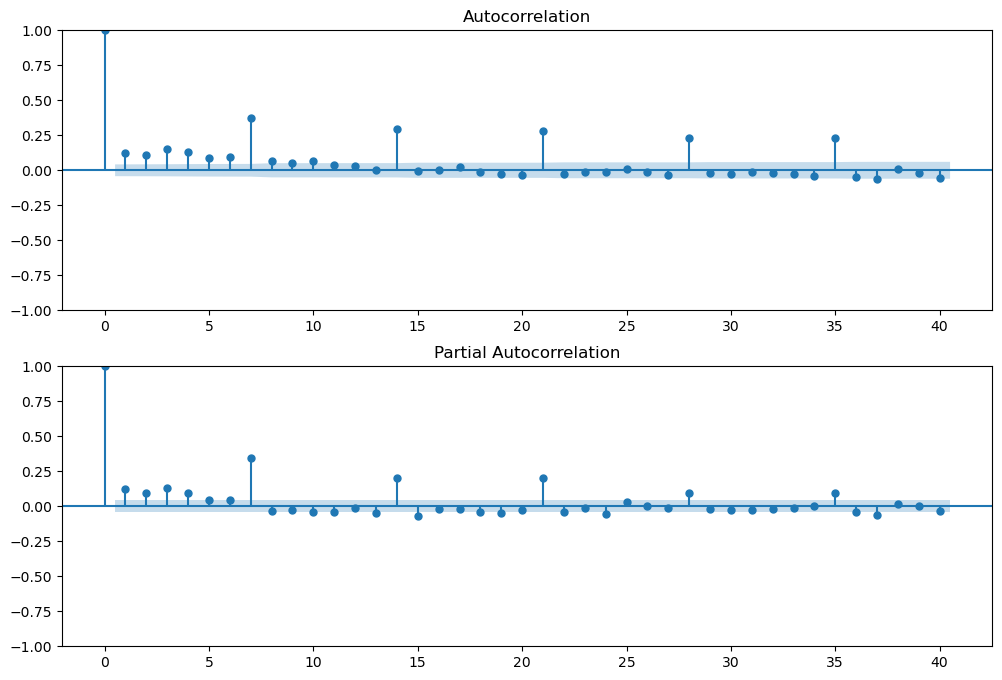

In [73]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(best_store_sales_trend, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(best_store_sales_trend, lags=40, ax=ax2)# , lags=40

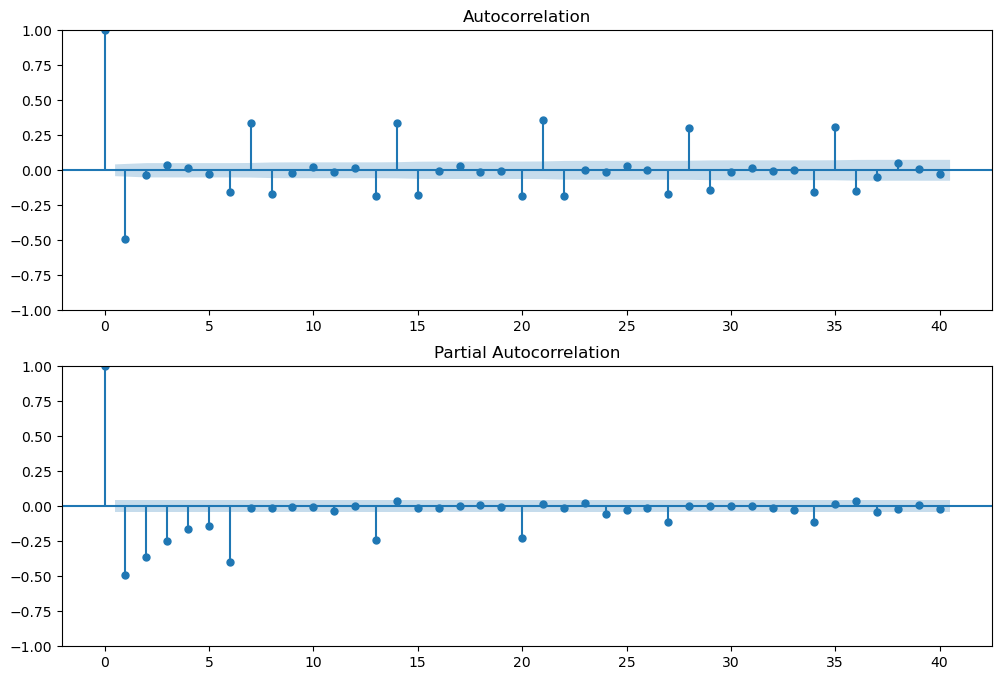

In [74]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

In [75]:
best_store_sales_trend

day_count
1431    1.247474
1432    2.316737
1433    1.247474
1434    1.069263
1435    0.000000
          ...   
3595    1.470237
3596    2.031600
3597    0.000000
3598    1.871210
3599    2.138526
Name: 1070, Length: 2169, dtype: float64

In [ ]:
arima_mod6 = ARIMA(best_store_sales_trend, order=(6,1,0)).fit()
print(arima_mod6.summary())

In [ ]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(best_store_sales_trend, trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())

In [ ]:
trend_df

In [ ]:
trend_df.index[0]

In [ ]:
trend_df.index[-1]

#### generate df for the best trend store(1070) that we will can predict pretty well

In [ ]:
df_of_models = pd.DataFrame(best_store_sales_trend)
df_of_models["date"] = pd.date_range(start=trend_df.index[0], end=trend_df.index[-1], freq='D')
df_of_models = df_of_models.set_index("date")

df_of_models.rename(columns = {1070:'sales of store: 1070'}, inplace = True)
df_of_models

In [ ]:
tr_start,tr_end = '2017-01-02','2022-09-30'
te_start,te_end = '2017-09-01','2017-12-11'
tra = df_of_models['sales of store: 1070'][tr_start:tr_end].dropna()
tes = df_of_models['sales of store: 1070'][te_start:te_end].dropna()

#### Applying ADF(Augmented Dicky-Fuller) test for find stationary

In [ ]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

’c’ : constant only (default)
’ct’ : constant and trend
’ctt’ : constant, and linear and quadratic trend
’nc’ : no constant, no trend

In [ ]:
df_of_models

In [ ]:
result = adfuller(df_of_models['2017-01-02':], regression='ct')
print('p-value:{}'.format(result[1]))

In [ ]:
result = adfuller(df_of_models['2017-01-02':].diff().dropna(), regression='c')
print('p-value:{}'.format(result[1]))

In [ ]:
tr_start,tr_end ='2021-01-01','2022-06-01'
te_start,te_end = '2022-06-01','2022-12-10'
tra = df_of_models['sales of store: 1070'].loc[tr_start:tr_end].dropna()
tes = df_of_models['sales of store: 1070'].loc[te_start:te_end].dropna()

In [ ]:
df_of_models[df_of_models['sales of store: 1070'] == 0]

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(tra, 'b', label='Train')
plt.plot(tes, 'r', label='Test')
plt.title("Top trend Store(1070) train and test split")
plt.xlabel("Date")
plt.ylabel("Relative sale")
plt.legend()
plt.show()

In [ ]:
sum_df

# 3.Models selection

## ARIMA model

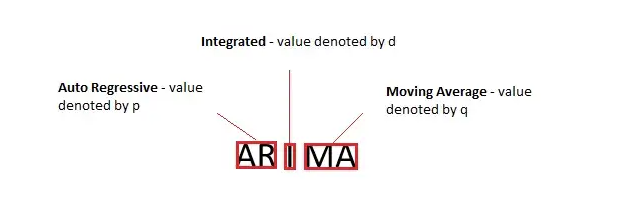

P = lags in the autoregressive model.
D = differencing / integration order.
Q =  moving average lags.

It's easy to determin I. In our case, we see the first order differencing make the ts stationary. I = 1.
AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use AR = 6




## SARIMA 

SARIMA similarly uses past values but also takes into account any seasonality patterns like we have in our data (every 365 days = 1 year)

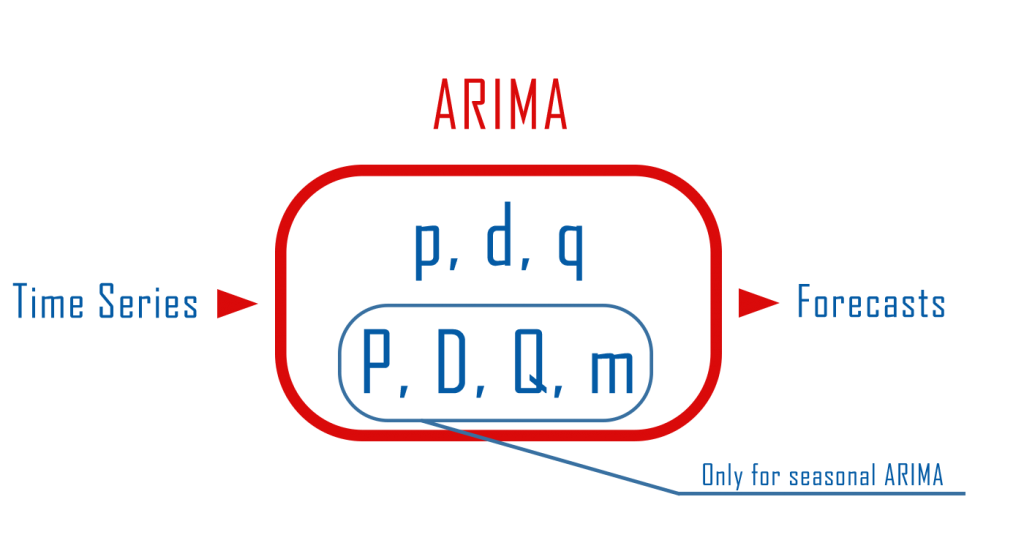

#### I took these parameters from a model that did a good job on product sales data with the same seasonality as ours

In [ ]:
SARIMAX_1 = sm.tsa.statespace.SARIMAX(tra, order=(0, 1, 6), seasonal_order=(0, 1, 1, 7)).fit(method='powell', disp=False)
SARIMAX_1.summary()

In [ ]:
res = SARIMAX_1.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [ ]:
pred_1 = SARIMAX_1.predict(tr_end,te_end)
print('SARIMA model MSE:{}'.format(mean_squared_error(tes,pred_1)))

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Store 1070 relative sales with SARIMAX (0, 1, 6)x(0, 1, [1], 7)")
plt.plot(tra[450:], label="Train data")
plt.plot(tes[:50], color='r',  label="Test data")
plt.plot(pred_1[:50],'--', color='g',  label="Predict data")
plt.xlabel("Date")
plt.ylabel("Relative Sales")
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()

In [ ]:
model_2 = sm.tsa.statespace.SARIMAX(
    tra, order=(0, 1, 4), seasonal_order=(0, 1, 1, 7)).fit(method='powell')
model_2.summary()

In [ ]:
res = model_2.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [ ]:
pred_2 = model_2.predict(tr_end,te_end)
print('SARIMA model MSE:{}'.format(mean_squared_error(tes,pred_2)))

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Store 1070 relative sales with SARIMAX (0, 1, 4)x(0, 1, [1], 7)	")
plt.plot(tra[450:], label="Train data")
plt.plot(tes[:50], color='r',  label="Test data")
plt.plot(pred_2[:50],'--', color='g',  label="Predict data")
plt.xlabel("Date")
plt.ylabel("Relative Sales")
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()

#### the result are ok but not look very good.

#### In fact, our ultimate goal is to build a strategy for the store that will contain the amount of products needed with a deviation of 95 percent. Most of the products, if not all, have a validity of more than a single day. In fact, if you stock up on food products, it can range from a week to months. And other products can be valid from weeks to years.
#### A resolution of a day is too high a resolution for the problem. We will continue the research in the second notebook, the resolution will also decrease for months and check more models....